In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict
from sklearn.metrics import adjusted_rand_score
from scipy.stats import rankdata
import itertools

In [3]:
from pygraphs.cluster import KernelKMeans, Ward, KernelKMeansSklearn, KernelWardSklearn
from pygraphs.graphs.generator import StochasticBlockModel, RubanovModel
from pygraphs.measure import *
from pygraphs.measure import H_kernels_plus_RSP_FE_SP_CT, scaler
from pygraphs.scenario import plot_results, d3_right_order, measures_right_order, ParallelByGraphs, RejectCurve
from pygraphs.scorer import rand_index

# Но скорее дело обстоит иначе. Ступенчатая кривая может быть связана со специфическим априорным упорядочением пар вершин, определяющим порядок при равном SP. Вертикальные участки могут быть из-за того, что четверть пар одноклассников, имеющих то же SP, что предыдущие, априори стоят позже и потому оказываются в конце. Предлагаю сделать вот что. К каждому SP прибавлять случайное число, распределенное равномерно, скажем, на $[-1/3, 1/3]$ (или меньшем симм. интервале), чтобы снять влияние априорного упорядочения. Как это повлияет на ступенчатость?

In [4]:
class randomized_SP(SP):
    name = 'randomized SP'
    
    def get_D(self, param):
        D = super().get_D(param)
        noise = np.random.uniform(low=-1./3, high=1./3, size=D.shape)
        for i in range(D.shape[0]):
            for j in range(i + 1, D.shape[1]):
                noise[j][i] = noise[i][j]
            noise[i][i] = 0
        return D + noise

In [5]:
rc = RejectCurve([(100, 2, 0.3, 0.1)], [SP, randomized_SP], StochasticBlockModel)
rc.set_best_params({(100, 2, 0.3, 0.1): {'SP': 0, 'randomized SP': 0}})

In [6]:
results_noshuffle = rc.perform(100, need_shuffle=False)
results_shuffle = rc.perform(100, need_shuffle=True)

In [14]:
results_noshuffle[(100, 2, 0.3, 0.1)]['SP']

100

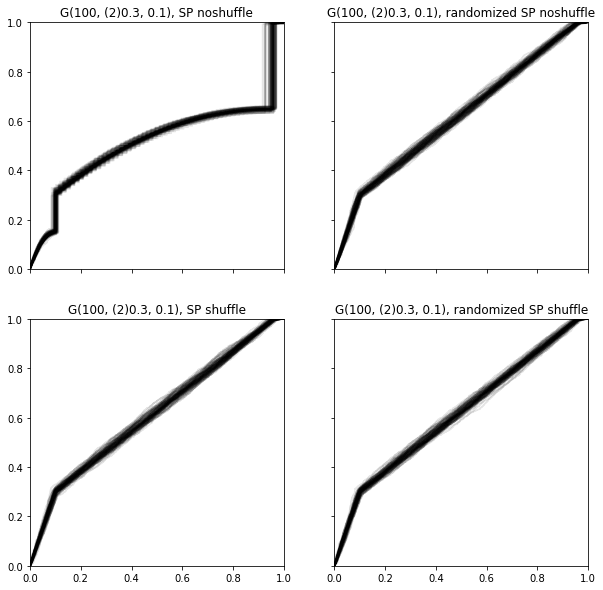

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
column = (100, 2, 0.3, 0.1)
for measure_name_idx, measure_name in enumerate(['SP', 'randomized SP']):
    axi = ax[0][measure_name_idx]
    for graph_idx, (tpr, fpr) in enumerate(results_noshuffle[column][measure_name]):
        axi.plot(tpr, fpr, color='black', alpha=0.1)

    axi.set_title("G({}, ({}){}, {}), {} noshuffle".format(*column, measure_name))
    axi.set_xlim(0, 1)
    axi.set_ylim(0, 1)
    
    axi = ax[1][measure_name_idx]
    for graph_idx, (tpr, fpr) in enumerate(results_shuffle[column][measure_name]):
        axi.plot(tpr, fpr, color='black', alpha=0.1)

    axi.set_title("G({}, ({}){}, {}), {} shuffle".format(*column, measure_name))
    axi.set_xlim(0, 1)
    axi.set_ylim(0, 1)